# HW4 - Graph Neural Networks

## Course Name: Analysis of Medical Images
#### Lecturers: Dr. Rohban
#### Name: Amir Mohammad Ezzati
#### Student ID: 402212269

---

**Contact**: Ask your questions in Quera

---

### Instructions:
- Complete all exercises presented in this notebook.
- Ensure you run each cell after you've entered your solution.




# Introduction

This notebook is designed to introduce you to the basics of Graph Neural Networks (GNNs) using a dataset of pathology images. The steps you will follow are:

- Download the Dataset: Access and download a set of pathology images.
- Data Preprocessing: Prepare the data for processing.
- Nuclei Extraction: Identify the location and dimensions of nuclei in the images.
- GNN Model Implementation: Develop a GNN for classification.
- Experiments: Conduct experiments to test the effectiveness of your model.

You are encouraged to use relevant libraries, but please provide brief explanations for your choices and describe how they work.

## Requirements

In [ ]:
!pip install histomicstk --find-links https://girder.github.io/large_image_wheels
!pip install ogb
!pip install gdown
!pip install torchvision
!pip install torch_geometric

Looking in links: https://girder.github.io/large_image_wheels


In [ ]:
!pip install histocartography
!pip install dgl

In [ ]:
# addressing some import errors and warnings
!wget https://raw.githubusercontent.com/BiomedSciAI/histocartography/main/histocartography/preprocessing/nuclei_extraction.py
!cat '/content/nuclei_extraction.py' > '/usr/local/lib/python3.10/dist-packages/histocartography/preprocessing/nuclei_extraction.py'
!sed -i 's/grey/gray/g' '/usr/local/lib/python3.10/dist-packages/histocartography/preprocessing/feature_extraction.py'

--2023-12-25 19:20:23--  https://raw.githubusercontent.com/BiomedSciAI/histocartography/main/histocartography/preprocessing/nuclei_extraction.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11039 (11K) [text/plain]
Saving to: ‘nuclei_extraction.py.1’

nuclei_extraction.p 100%[===================>]  10.78K  --.-KB/s    in 0s      

2023-12-25 19:20:23 (78.8 MB/s) - ‘nuclei_extraction.py.1’ saved [11039/11039]



## Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import histomicstk as htk  # HistomicsTK for pathology image analysis
import numpy as np
import scipy as sp
import skimage.io
import skimage.measure
import skimage.color
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import torch.nn as nn

import copy
from google.colab import drive

from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
import os
from glob import glob
import argparse
from PIL import Image
from tqdm import tqdm
import torch
import dgl
from dgl.data.utils import save_graphs, load_graphs
from torch_geometric.utils.convert import from_dgl

from histocartography.utils import download_example_data
from histocartography.preprocessing import (
    NucleiExtractor,
    DeepFeatureExtractor,
    KNNGraphBuilder
)
from histocartography.visualization import OverlayGraphVisualization, InstanceImageVisualization

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

We will use the BRACS test dataset, a collection of Hematoxylin and Eosin (H&E) stained histopathological images for breast tumor classification. The dataset includes over 4,000 tumor regions-of-interest labeled in 7 categories. You can download it using the following commands. Alternatively, you may use any suitable dataset, but ensure it is accessible during evaluation.

In [ ]:
# helper fuctions for accessing data and path variable
project_path = '/content/drive/MyDrive/SPB/HW4/'

def get_graph_path(path, format='bin'):
    # Add your preprocessing steps here
    # print(sub_dirs)
    all_graph_path = []
    a_format = '*.'+format
    all_graph_path.extend(glob(os.path.join(path, a_format)))

    return all_graph_path

def get_image_path(project_path):
    # Add your preprocessing steps here
    data_path = project_path + 'data/'
    sub_dirs = [x[0] for x in os.walk(data_path)] # all subdirs of data_path(0_N, 1_PB, ...)
    all_image_path = []
    for sub_dir in sub_dirs:
      all_image_path.extend(glob(os.path.join(sub_dir, '*.png')))

    return all_image_path

## Preprocessing and Graphic Model Extraction (15 points)

In this section, you will preprocess the images to facilitate model training. Then, identify the position and dimensions of cells using either classic methods or neural networks. Finally, use a neural network (e.g., ResNet18) to embed cell information for node embedding in the GNN.


In [ ]:
# HoverNet model path for nuclei extraction
nuclei_extractor_model_pannuke_path = project_path + 'nuclei extractor model/hovernet_monusac.pt'
nuclei_extractor_model_monusac_path = project_path + 'nuclei extractor model/hovernet_pannuke.pt'

In [ ]:
# this code is for cell graph generation with Histocartography library
# this function contains nuclei extraction, feature extraction, and graph builder steps in its pipeline. so no need to data preprocessing

def generate_cell_graph(project_path):
    os.makedirs(os.path.join(project_path+'output', 'cell_graphs'), exist_ok=True)
    os.makedirs(os.path.join(project_path+'output', 'cell_graphs_visualized'), exist_ok=True)

    # 1. get image path
    all_image_path = get_image_path(project_path)
    print('number of image: ', len(all_image_path))

    # 2. define nuclei extractor
    nuclei_detector = NucleiExtractor(model_path=nuclei_extractor_model_pannuke_path)

    patch_size = 100
    # 3. define feature extractor
    feature_extractor = DeepFeatureExtractor(
        architecture='resnet18',
        patch_size=patch_size,
        resize_size=224
    )

    # 4. define k-NN graph builder with k=5 and thresholding edges longer than 50 pixels. Add image size-normalized centroids to the node features.
    # resulting node features are 512 features from ResNet18 + 2  normalized centroid features.
    knn_graph_builder = KNNGraphBuilder(k=5, thresh=50, add_loc_feats=True)

    # 5. define graph visualizer
    visualizer = OverlayGraphVisualization()

    graphs_path = get_graph_path(project_path+'output/cell_graphs', format='bin')
    # 6. process all the images
    for image_path in tqdm(all_image_path[549:]):
        # print(image_path)
        _, image_name = os.path.split(image_path)
        fname = image_name.replace('.png', '.bin')

        if os.path.join(project_path+'output', 'cell_graphs', fname) not in graphs_path:
          # count+=1
          # print(count)
          # a. load image
          image = np.array(Image.open(image_path))

          # b. extract nuclei
          nuclei_map, _ = nuclei_detector.process(image)
          # print(_.shape)
          # print(nuclei_map[0][:100]>0)
          # print('image size: ', image.shape)

          # c. extract deep features
          features = feature_extractor.process(image, nuclei_map)
          # print(features.shape)
          # d. build a kNN graph
          graph = knn_graph_builder.process(nuclei_map, features)

          # print('Number of nodes:', graph.number_of_nodes())
          # print('Number of edges:', graph.number_of_edges())
          # e. save the graph

          save_graphs(os.path.join(project_path+'output', 'cell_graphs', fname), [graph])

          # f. visualize and save the graph
          # canvas = visualizer.process(image, graph, instance_map=nuclei_map)
          # canvas.save(os.path.join(project_path+'output', 'cell_graphs_visualized', image_name))

          # visualize(image_path)

### **Graph generation**

**Hint: Following two cells take much time to run(~6-7hours on GPU). so I ran it once and saved the graph data on google drive for further usage**

In [ ]:
# generate_cell_graph(project_path)

In [ ]:
# generate_cell_graph(project_path)

## Visualization (3 points)

Visualize the results to check accuracy and quality. For example, display a random pathology image alongside the graph of adjacent nuclei.


In [ ]:
# Visualization code here
def visualize(image_path):
  image = np.array(Image.open(image_path))

  nuclei_detector = NucleiExtractor(model_path=nuclei_extractor_model_pannuke_path)
  nuclei_map, _ = nuclei_detector.process(image)

  feature_extractor = DeepFeatureExtractor(
        architecture='resnet18',
        patch_size=100,
        resize_size=224
  )
  features = feature_extractor.process(image, nuclei_map)

  knn_graph_builder = KNNGraphBuilder(k=5, thresh=50, add_loc_feats=True)
  graph = knn_graph_builder.process(nuclei_map, features)

  visualizer = InstanceImageVisualization()
  viz_nuclei = visualizer.process(image, instance_map=nuclei_map)

  # Visualize the resulting cell graph
  visualizer = OverlayGraphVisualization(
      instance_visualizer=InstanceImageVisualization(
          instance_style="filled+outline"
      )
  )
  viz_cg = visualizer.process(
    canvas=image,
    graph=graph,
    instance_map=nuclei_map
  )

  fig,axs = plt.subplots(1,3, figsize=(30,30))
  axs[0].title.set_text('normal')
  axs[0].imshow(image)
  axs[1].title.set_text('segmented nuclei')
  axs[1].imshow(viz_nuclei)
  axs[2].title.set_text('cell graph')
  axs[2].imshow(viz_cg)

Patch-level nuclei detection: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


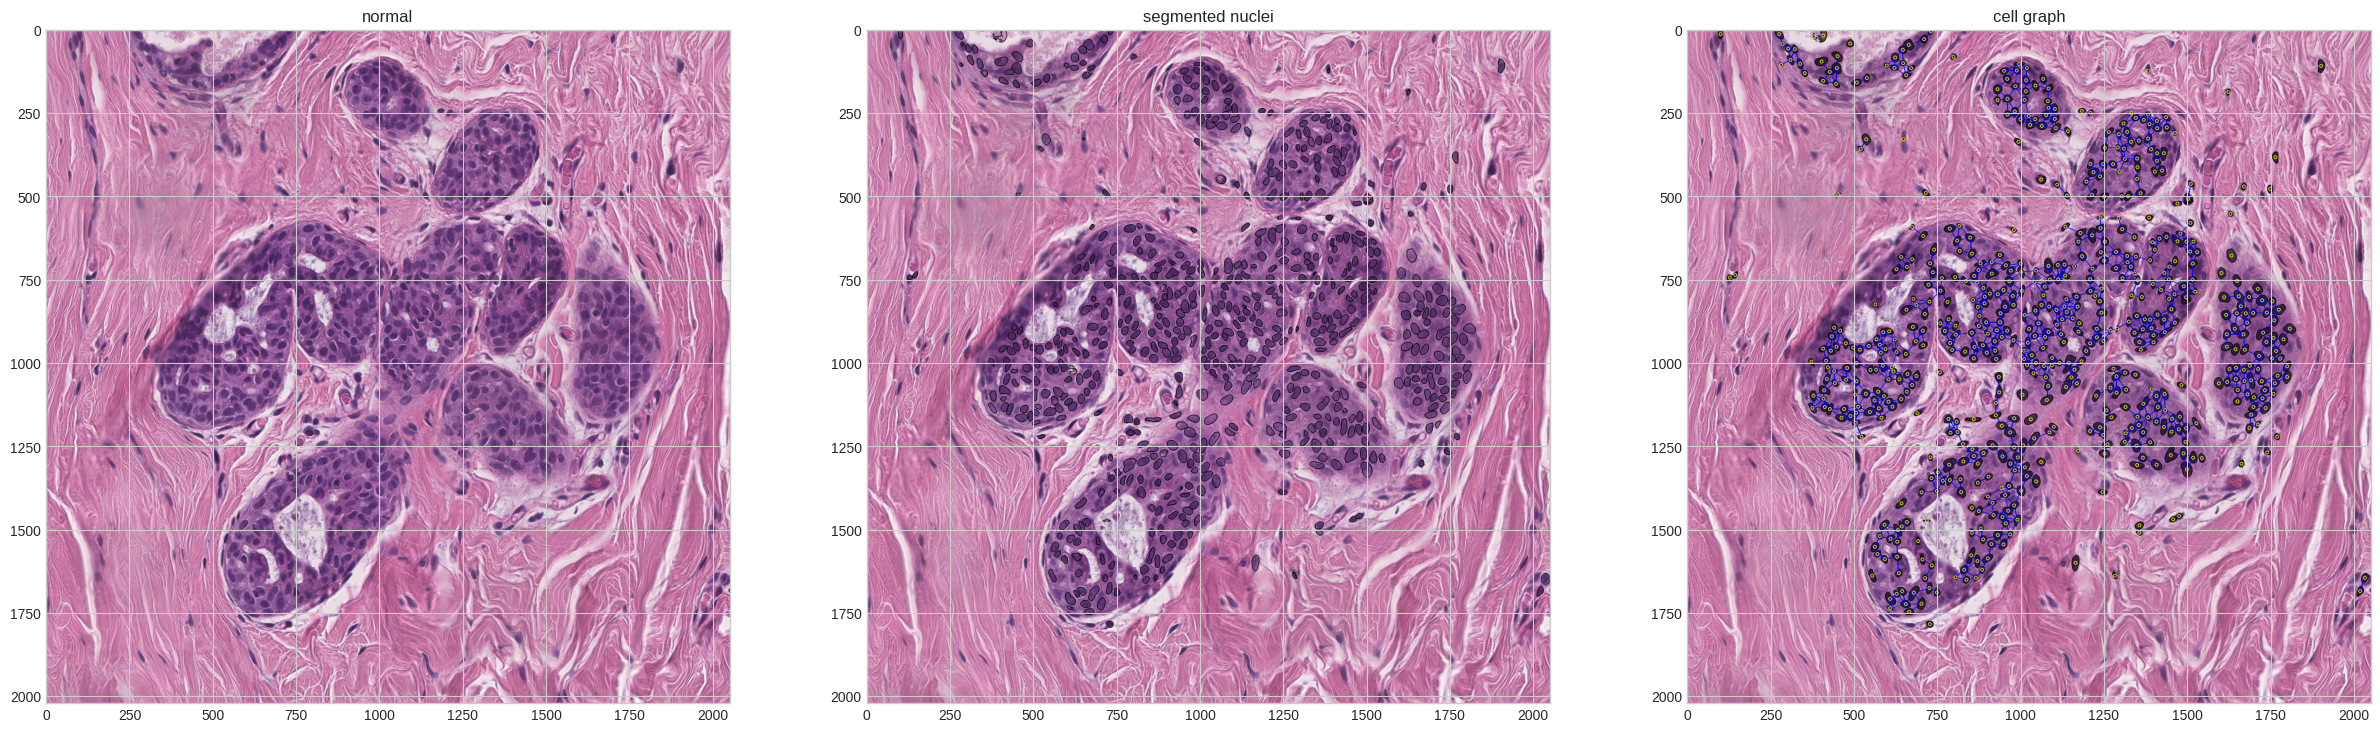

In [ ]:
# random visualization
images_path = get_image_path(project_path)
index = np.random.randint(len(images_path))

visualize(images_path[index])

## Dataset Object

Create a dataset class suitable for your data. You may use geometric_Dataset, Dataset, or any other method. Please explain your implementation logic if you choose an alternative approach.

In [ ]:
graph_directory = project_path + 'output/cell_graphs/'

labelToClassIndex = {
    'N': 0,
    'PB': 1,
    'UDH': 2,
    'ADH': 3,
    'FEA': 4,
    'DCIS': 5,
    'IC': 6
}

In [ ]:
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Dataset as geometric_Dataset
from torch_geometric.data import Data


class PathologyDataset(geometric_Dataset):
    def __init__(self, directory):
        self.graph_path_list = get_graph_path(directory, format='bin')
        self.max_nodes = None
        # print(self.graph_path_list)

    def __len__(self):
        return len(self.graph_path_list)

    def __getitem__(self, idx):
        graph_path = self.graph_path_list[idx]
        graph = load_graphs(graph_path)[0][0]

        nodes_num = graph.number_of_nodes()
        # graph = dgl.remove_nodes(graph, torch.tensor([i for i in range(nodes_num - self.max_nodes)]))

        file_name = graph_path.split('/')[-1].split('.')[0]
        label = file_name.split('_')[-2]

        class_ = labelToClassIndex[label]

        geo_data = from_dgl(graph)
        geo_data.x = geometric_data.feat
        geo_data.y = class_
        # print(class_)
        return geo_data

    def get_idx_split(self):
        indices = [i for i in range(len(self.graph_path_list))]

        train_indices, val_test_indices = train_test_split(indices, test_size=0.2, random_state=0)
        val_indices , test_indices = train_test_split(val_test_indices, test_size=0.5, random_state=0)

        return {'train': train_indices, 'val': val_indices, 'test': test_indices}

In [ ]:
ds = PathologyDataset(graph_directory)
split_idx = ds.get_idx_split()

In [ ]:
# ds[split_idx["train"]]

In [ ]:
ds[100][0].ndata['feat']

tensor([[9.2610e-02, 1.2685e-01, 5.7619e-02,  ..., 7.6120e-01, 1.1629e-01,
         4.0958e-03],
        [1.9315e-01, 7.2248e-02, 3.0729e-02,  ..., 9.4561e-02, 1.2443e-01,
         1.2602e-03],
        [5.3006e-01, 4.3660e-01, 6.5004e-02,  ..., 7.6444e-01, 3.5724e-01,
         2.8355e-03],
        ...,
        [9.9582e-02, 3.6183e-02, 2.0359e-01,  ..., 1.5997e+00, 6.7624e-01,
         9.9748e-01],
        [0.0000e+00, 1.7842e-02, 9.2965e-02,  ..., 1.0717e+00, 4.2421e-01,
         9.9842e-01],
        [9.4264e-01, 3.5468e-01, 4.4307e-01,  ..., 6.2904e-01, 7.0339e-01,
         9.9842e-01]])

In [ ]:
ds[100][0].adj()

SparseMatrix(indices=tensor([[   0,    0,    0,  ..., 2399, 2399, 2401],
                             [   1,   27,   39,  ..., 2383, 2401, 2399]]),
             values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             shape=(2403, 2403), nnz=4063)

In [ ]:
ds100.adj()

SparseMatrix(indices=tensor([[   2,    5,    6,  ..., 1899, 1899, 1901],
                             [  20,   22,   16,  ..., 1883, 1901, 1899]]),
             values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             shape=(1903, 1903), nnz=3326)

In [ ]:
ds100 = dgl.remove_nodes(ds[100][0], torch.tensor([i for i in range(500)]))

In [ ]:
print(ds[100][0].number_of_nodes())
print(ds100.number_of_nodes())

2403
0


## GCN Model Implementation (25 points)

Implement the GCN model as per the provided architecture. Ensure each step is well-documented. [Please follow the figure below to implement your `forward` function.]

![test](https://drive.google.com/uc?id=128AuYAXNXGg7PIhJJ7e420DoPWKb-RtL)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):
        # TODO: Implement a function that initializes self.convs,
        # self.bns, and self.softmax.

        super(GCN, self).__init__()

        # A list of GCNConv layers
        self.convs = None

        # A list of 1D batch normalization layers
        self.bns = None

        # The log softmax layer
        self.softmax = None

        ############# Your code here ############
        ## Note:
        ## 1. You should use torch.nn.ModuleList for self.convs and self.bns
        ## 2. self.convs has num_layers GCNConv layers
        ## 3. self.bns has num_layers - 1 BatchNorm1d layers
        ## 4. You should use torch.nn.LogSoftmax for self.softmax
        ## 5. The parameters you can set for GCNConv include 'in_channels' and
        ## 'out_channels'. For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        ## 6. The only parameter you need to set for BatchNorm1d is 'num_features'
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

        self.convs = torch.nn.ModuleList(
            [GCNConv(in_channels=input_dim, out_channels=hidden_dim)] +
            [GCNConv(in_channels=hidden_dim, out_channels=hidden_dim)
                for i in range(num_layers-2)] +
            [GCNConv(in_channels=hidden_dim, out_channels=output_dim)]
        )
        self.bns = torch.nn.ModuleList([
            torch.nn.BatchNorm1d(num_features=hidden_dim)
                for i in range(num_layers-1)
        ])
        #########################################

        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        # TODO: Implement a function that takes the feature tensor x and
        # edge_index tensor adj_t and returns the output tensor as
        # shown in the figure.

        out = None

        ############# Your code here ############
        ## Note:
        ## 1. Construct the network as shown in the figure
        ## 2. torch.nn.functional.relu and torch.nn.functional.dropout are useful
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/nn.functional.html
        ## 3. Don't forget to set F.dropout training to self.training
        ## 4. If return_embeds is True, then skip the last softmax layer

        for conv, bn in zip(self.convs[:-1], self.bns):
            x = F.relu(bn(conv(x, adj_t)))
            if self.training:
                x = F.dropout(x, p=self.dropout)

        x = self.convs[-1](x, adj_t)
        out = x if self.return_embeds else self.softmax(x)
        #########################################

        return out

## Graph Prediction Model (15 points)

Implement a GCN Graph Prediction model using the node embeddings from the GCN model and global pooling to create graph-level embeddings.

### Graph Mini-Batching
Before diving into the actual model, we introduce the concept of mini-batching with graphs. In order to parallelize the processing of a mini-batch of graphs, PyG combines the graphs into a single disconnected graph data object (*torch_geometric.data.Batch*). *torch_geometric.data.Batch* inherits from *torch_geometric.data.Data* (introduced earlier) and contains an additional attribute called `batch`.

The `batch` attribute is a vector mapping each node to the index of its corresponding graph within the mini-batch:

    batch = [0, ..., 0, 1, ..., n - 2, n - 1, ..., n - 1]

This attribute is crucial for associating which graph each node belongs to and can be used to e.g. average the node embeddings for each graph individually to compute graph level embeddings.


### Implemention
Now, we have all of the tools to implement a GCN Graph Prediction model!  

We will reuse the existing GCN model to generate `node_embeddings` and then use  `Global Pooling` over the nodes to create graph level embeddings that can be used to predict properties for the each graph. Remeber that the `batch` attribute will be essential for performining Global Pooling over our mini-batch of graphs.


In [ ]:
from ogb.graphproppred.mol_encoder import AtomEncoder
from torch_geometric.nn import global_add_pool, global_mean_pool

### GCN to predict graph property
class GCN_Graph(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout, pool=None):
        super(GCN_Graph, self).__init__()

        # Load encoders for Atoms in molecule graphs
        self.node_encoder = AtomEncoder(hidden_dim)

        # Node embedding model
        # Note that the input_dim and output_dim are set to hidden_dim
        self.gnn_node = GCN(hidden_dim, hidden_dim,
            hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = None

        ############# Your code here ############
        ## Note:
        ## 1. Initialize self.pool as a global mean pooling layer
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        if pool:
          self.pool = pool
        else:
          self.pool = global_mean_pool
        #########################################

        # Output layer
        self.linear = torch.nn.Linear(hidden_dim, output_dim)


    def reset_parameters(self):
      self.gnn_node.reset_parameters()
      self.linear.reset_parameters()

    def forward(self, batched_data):
        # TODO: Implement a function that takes as input a
        # mini-batch of graphs (torch_geometric.data.Batch) and
        # returns the predicted graph property for each graph.
        #
        # NOTE: Since we are predicting graph level properties,
        # your output will be a tensor with dimension equaling
        # the number of graphs in the mini-batch


        # Extract important attributes of our mini-batch
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        embed = self.node_encoder(x)

        out = None

        ############# Your code here ############
        ## Note:
        ## 1. Construct node embeddings using existing GCN model
        ## 2. Use the global pooling layer to aggregate features for each individual graph
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        ## 3. Use a linear layer to predict each graph's property

        embed = self.gnn_node(embed, edge_index)
        features = self.pool(embed, batch)
        out = self.linear(features)
        #########################################

        return out

In [ ]:
def train(model, device, data_loader, optimizer, loss_fn):
    # TODO: Implement a function that trains your model by
    # using the given optimizer and loss_fn.
    model.train()
    loss = 0

    for step, batch in enumerate(tqdm(data_loader, desc="Iteration")):
      batch = batch.to(device)

      if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
          pass
      else:
        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y

        ############# Your code here ############
        ## Note:
        ## 1. Zero grad the optimizer
        ## 2. Feed the data into the model
        ## 3. Use `is_labeled` mask to filter output and labels
        ## 4. You may need to change the type of label to torch.float32
        ## 5. Feed the output and label to the loss_fn
        ## (~3 lines of code)

        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out[is_labeled], batch.y[is_labeled].float())
        #########################################

        loss.backward()
        optimizer.step()

    return loss.item()

In [ ]:
from tqdm import tqdm

# The evaluation function
def eval(model, device, loader, evaluator, save_model_results=False, save_file=None):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    if save_model_results:
        print ("Saving Model Predictions")

        # Create a pandas dataframe with a two columns
        # y_pred | y_true
        data = {}
        data['y_pred'] = y_pred.reshape(-1)
        data['y_true'] = y_true.reshape(-1)

        df = pd.DataFrame(data=data)
        # Save to csv
        df.to_csv('our_graph_' + save_file + '.csv', sep=',', index=False)

    return evaluator.eval(input_dict)

## Traing and Testing

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
args = {'device': device, 'num_layers': 5, 'hidden_dim': 256, 'dropout': 0.5, 'lr': 0.001, 'epochs': 30}

In [ ]:
class Evaluator():
  def __init__(self) -> None:
      pass
  def eval(self, input_dict):
    # calculate evaluation metrics
    pass

In [ ]:
graph_directory = project_path + 'output/cell_graphs/'

evaluator = Evaluator()
dataset = PathologyDataset(graph_directory)

# Ex. DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=0)
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False, num_workers=0)
val_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False, num_workers=0)

In [ ]:
model = GCN_Graph(
    args['hidden_dim'], dataset.num_tasks, args['num_layers'], args['dropout']).to(device)

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.BCEWithLogitsLoss()

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):

    print('Training...')
    loss = train(model, device, train_loader, optimizer, loss_fn)

    print('Evaluating...')
    train_result = eval(model, device, train_loader, evaluator)
    val_result = eval(model, device, val_loader, evaluator)
    test_result = eval(model, device, test_loader, evaluator)

    train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[dataset.eval_metric]
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)

    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {100 * train_acc:.2f}%, Valid: {100 * valid_acc:.2f}% Test: {100 * test_acc:.2f}%')

## Other Experiments (5 points)

Experiment with different global pooling layers in PyTorch Geometric and observe the changes in model performance. [Two global pooling layers other than mean pooling in Pytorch Geometric.]

In [ ]:
# Experiment_1
# use global_max_pool
from torch_geometric.nn import global_max_pool

model = GCN_Graph(args['hidden_dim'],
            dataset.num_tasks, args['num_layers'],
            args['dropout'], global_max_pool).to(device)

evaluator = Evaluator()

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.BCEWithLogitsLoss()

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):

    print('Training...')
    loss = train(model, device, train_loader, optimizer, loss_fn)

    print('Evaluating...')
    train_result = eval(model, device, train_loader, evaluator)
    val_result = eval(model, device, val_loader, evaluator)
    test_result = eval(model, device, test_loader, evaluator)

    train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[dataset.eval_metric]
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)

    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {100 * train_acc:.2f}%, Valid: {100 * valid_acc:.2f}% Test: {100 * test_acc:.2f}%')


In [ ]:
# Experiment_2
# use global_add_pool
from torch_geometric.nn import global_add_pool

model = GCN_Graph(args['hidden_dim'],
            dataset.num_tasks, args['num_layers'],
            args['dropout'], global_add_pool).to(device)
evaluator = Evaluator()

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.BCEWithLogitsLoss()

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):

    print('Training...')
    loss = train(model, device, train_loader, optimizer, loss_fn)

    print('Evaluating...')
    train_result = eval(model, device, train_loader, evaluator)
    val_result = eval(model, device, val_loader, evaluator)
    test_result = eval(model, device, test_loader, evaluator)

    train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[dataset.eval_metric]
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)

    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {100 * train_acc:.2f}%, Valid: {100 * valid_acc:.2f}% Test: {100 * test_acc:.2f}%')


Important Reminder: The functions provided in this notebook serve as initial templates and examples. You are encouraged to modify and adapt them as needed to suit your specific requirements or to improve performance. However, while making these changes, please endeavor to preserve the overall structure and objectives of the exercise.
